## GBDT(Gradient Boosting Decision Tree)

Boosting则是一种集成学习模式，通过将多个单个决策树(弱学习器)进行线性组合构成一个强学习器的过程，Boosting以一个单模型作为作为弱分类器，GBDT中使用CART作为这种弱学习器(基模型)。而融入了梯度下降对Boosting树模型进行优化之后就有了梯度提升树模型。

## 通俗来说，就是通过下一个分类器拟合上一步结果的残差

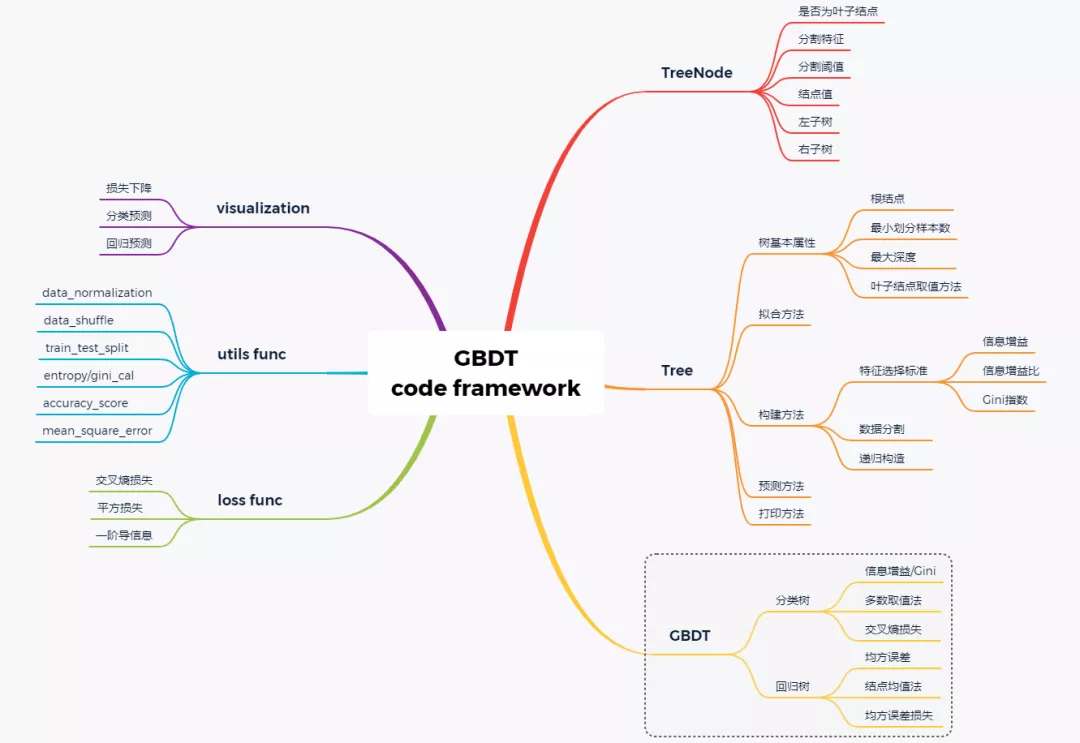

<font siza=3>定义代码框架，主要包括树的基本属性和方法。基本属性包括根结点、最小划分样本数、最大深度和是否为叶子结点等等。基本方法包括决策树构建、决策树拟合、决策树预测和打印等方法。

## 提升树

以决策树为基函数的提升方法

### 对于分类问题，将adaboost中的基本分类器限制为二类分裂树即可，对于回归问题的提升树算法，对上一步残差拟合

我们先来用一个通俗的说法来理解GBDT。假设某位同学月薪10k，笔者先用一个树模型拟合了6k，发现有4k的损失，然后再用一棵树模型拟合了2k，这样持续拟合下去，拟合值和目标值之间的残差会越来越小，而我们将每一轮迭代，也就是每一棵树的预测值加起来就是模型最终的预测结果。不停的使用单棵决策树组合就是Boosting的过程，使用梯度下降对Boosting树模型进行优化的过程就是Gradient Boosting。

### 梯度提升：把损失函数的负梯度作为残差的估计，对于平方损失函数就是，一般的损失函数是近似

In [ ]:

class Tree(object):
    def __init__(self, min_samples_split=2, min_impurity=1e-7,
                 max_depth=float("inf"), loss=None):
        self.root = None  # Root node in dec. tree
        # Minimum n of samples to justify split
        self.min_samples_split = min_samples_split
        # The minimum impurity to justify split
        self.min_impurity = min_impurity
        # The maximum depth to grow the tree to
        self.max_depth = max_depth
        # Function to calculate impurity (classif.=>info gain, regr=>variance reduct.)
        # 切割树的方法，gini，方差等
        self._impurity_calculation = None
        # Function to determine prediction of y at leaf
        # 树节点取值的方法，分类树：选取出现最多次数的值，回归树：取所有值的平均值
        self._leaf_value_calculation = None
        # If y is one-hot encoded (multi-dim) or not (one-dim)
        self.one_dim = None
        # If Gradient Boost
        self.loss = loss

    def fit(self, X, y, loss=None):
        """ Build decision tree """
        pass

    def _build_tree(self, X, y, current_depth=0):
        """ Recursive method which builds out the decision tree and splits X and respective y """
        pass

    def predict_value(self, x, tree=None):
        """ Do a recursive search down the tree and make a prediction of the data sample by the
            value of the leaf that we end up at """
        pass

    def predict(self, X):
        """ Classify samples one by one and return the set of labels """
        pass

    def print_tree(self, tree=None, indent=" "):
        pass

In [52]:
# 以回归树为例，基于以上树模型，可定义回归树模型如下：
class RegressionTree(Tree):
    # 使用方差法进行树分割
    def _calculate_variance_reduction(self, y, y1, y2):
        var_tot = calculate_variance(y)
        var_1 = calculate_variance(y1)
        var_2 = calculate_variance(y2)
        frac_1 = len(y1) / len(y)
        frac_2 = len(y2) / len(y)
        # Calculate the variance reduction
        variance_reduction = var_tot - (frac_1 * var_1 + frac_2 * var_2)
        return sum(variance_reduction)
        
    # 使用均值法取叶子结点值
    def _mean_of_y(self, y):
        value = np.mean(y, axis=0)
        return value if len(value) > 1 else value[0]
        
    # 回归树拟合
    def fit(self, X, y):
        self._impurity_calculation = self._calculate_variance_reduction
        self._leaf_value_calculation = self._mean_of_y
        super(RegressionTree, self).fit(X, y)

In [53]:
class Loss(object):
    def loss(self, y_true, y_pred):
        return NotImplementedError()
    def gradient(self, y, y_pred):
        raise NotImplementedError()
    def acc(self, y, y_pred):
        return 0
        
class SquareLoss(Loss):
    def __init__(self): pass
    def loss(self, y, y_pred):
        return 0.5 * np.power((y - y_pred), 2)
    def gradient(self, y, y_pred):
        return -(y - y_pred)

In [54]:

class GBDT(object):
    def __init__(self, n_estimators, learning_rate, min_samples_split,
                 min_impurity, max_depth, regression):
        # 基本参数
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.max_depth = max_depth
        self.regression = regression
        self.loss = SquareLoss()
        if not self.regression:
            self.loss = SotfMaxLoss()
        # 分类问题也可以使用回归树，利用残差去学习概率
        self.estimators = []
        for i in range(self.n_estimators):
            self.estimators.append(RegressionTree(min_samples_split=self.min_samples_split,
                                             min_impurity=self.min_impurity,
                                             max_depth=self.max_depth))
    # 拟合方法
    def fit(self, X, y):
        # 让第一棵树去拟合模型
        print('kaishi')
        self.estimators[0].fit(X, y)
        print(self.estimators[0])
        y_pred = self.estimators[0].predict(X)
        print(y)
        print(y_pred)
        for i in range(1, self.n_estimators):
            gradient = self.loss.gradient(y, y_pred) #计算损失
            self.estimators[i].fit(X, gradient) #拟合残差
            y_pred -= np.multiply(self.learning_rate, self.estimators[i].predict(X))
    # 预测方法
    def predict(self, X):
        y_pred = self.estimators[0].predict(X)
        for i in range(1, self.n_estimators):
            y_pred -= np.multiply(self.learning_rate, self.estimators[i].predict(X))
        if not self.regression:
            # Turn into probability distribution
            y_pred = np.exp(y_pred) / np.expand_dims(np.sum(np.exp(y_pred), axis=1), axis=1)
            # Set label to the value that maximizes probability
            y_pred = np.argmax(y_pred, axis=1)
        return y_pred

In [55]:
# regression tree
class GBDTRegressor(GBDT):
    def __init__(self, n_estimators=200, learning_rate=0.5, min_samples_split=2,
                 min_var_red=1e-7, max_depth=4, debug=False):
        super(GBDTRegressor, self).__init__(n_estimators=n_estimators,
                                            learning_rate=learning_rate,
                                            min_samples_split=min_samples_split,
                                            min_impurity=min_var_red,
                                            max_depth=max_depth,
                                            regression=True)
# classification tree
class GBDTClassifier(GBDT):
    def __init__(self, n_estimators=200, learning_rate=.5, min_samples_split=2,
                 min_info_gain=1e-7, max_depth=2, debug=False):
        super(GBDTClassifier, self).__init__(n_estimators=n_estimators,
                                             learning_rate=learning_rate,
                                             min_samples_split=min_samples_split,
                                             min_impurity=min_info_gain,
                                             max_depth=max_depth,
                                             regression=False)
    def fit(self, X, y):
        y = to_categorical(y)
        super(GBDTClassifier, self).fit(X, y)